In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 36.4 MB/s 
     |████████████████████████████████| 182 kB 81.2 MB/s 
     |████████████████████████████████| 7.6 MB 35.6 MB/s 


## Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import re
import string
from tqdm import tqdm
from datetime import datetime 
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from datetime import datetime 
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the data

In [ ]:
dir_path = "/content/drive/MyDrive/Sarcasm Headlines Dataset"
df_1 = pd.read_json(os.path.join(dir_path, "Sarcasm_Headlines_Dataset.json"), lines=True)
df_2 = pd.read_json(os.path.join(dir_path, "Sarcasm_Headlines_Dataset_v2.json"), lines=True)
df =  pd.concat([df_1, df_2])

In [ ]:
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


## EDA and Data-Preprocessing

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55328 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  55328 non-null  object
 1   headline      55328 non-null  object
 2   is_sarcastic  55328 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


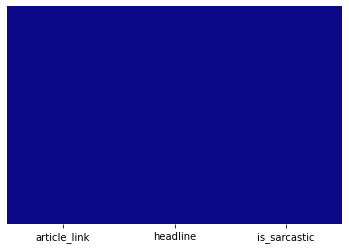

In [ ]:
sns.heatmap(data=df.isnull(), cbar=False, yticklabels=False, cmap='plasma')

In [ ]:
df.drop(columns=['article_link'], inplace=True)

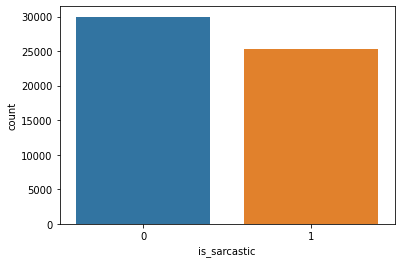

In [ ]:
sns.countplot(x='is_sarcastic', data=df)

In [ ]:
df['headline']

0        former versace store clerk sues over secret 'b...
1        the 'roseanne' revival catches up to our thorn...
2        mom starting to fear son's web series closest ...
3        boehner just wants wife to listen, not come up...
4        j.k. rowling wishes snape happy birthday in th...
                               ...                        
28614         jews to celebrate rosh hashasha or something
28615    internal affairs investigator disappointed con...
28616    the most beautiful acceptance speech this week...
28617    mars probe destroyed by orbiting spielberg-gat...
28618                   dad clarifies this not a food stop
Name: headline, Length: 55328, dtype: object

In [ ]:
df['headline'].str.split()

0        [former, versace, store, clerk, sues, over, se...
1        [the, 'roseanne', revival, catches, up, to, ou...
2        [mom, starting, to, fear, son's, web, series, ...
3        [boehner, just, wants, wife, to, listen,, not,...
4        [j.k., rowling, wishes, snape, happy, birthday...
                               ...                        
28614    [jews, to, celebrate, rosh, hashasha, or, some...
28615    [internal, affairs, investigator, disappointed...
28616    [the, most, beautiful, acceptance, speech, thi...
28617    [mars, probe, destroyed, by, orbiting, spielbe...
28618           [dad, clarifies, this, not, a, food, stop]
Name: headline, Length: 55328, dtype: object

In [ ]:
df['headline'].str.split().map(lambda x: len(x))

0        12
1        14
2        14
3        13
4        11
         ..
28614     7
28615    13
28616    12
28617     8
28618     7
Name: headline, Length: 55328, dtype: int64

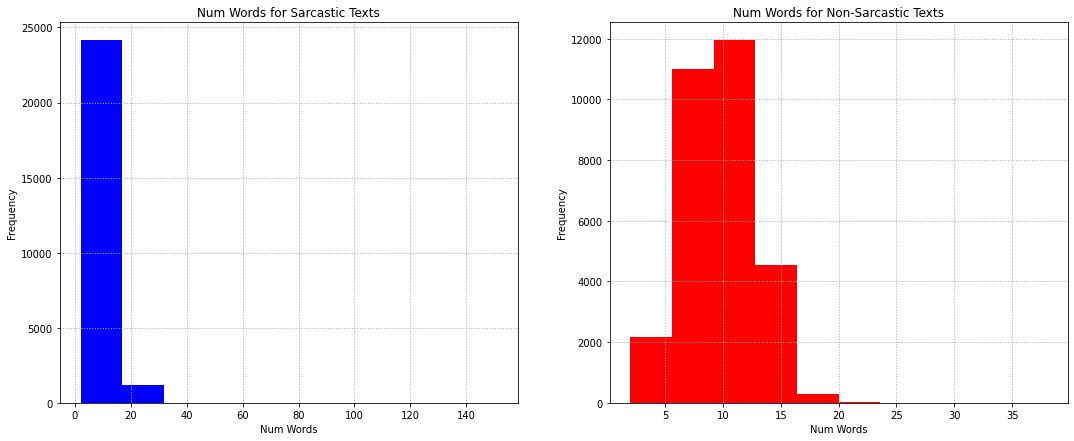

In [ ]:
#  Bar plot for no. of words in each headline

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7,7))

sar_num_words = df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x)).values
non_sar_num_words = df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x)).values

ax1.hist(sar_num_words, color='blue')
ax1.set_title('Num Words for Sarcastic Texts')
ax1.set_xlabel('Num Words', fontdict={'fontsize':10})
ax1.set_ylabel('Frequency', fontdict={'fontsize':10})
ax1.grid(linestyle='dotted', lw=1)

ax2.hist(non_sar_num_words, color='red')
ax2.set_title('Num Words for Non-Sarcastic Texts')
ax2.set_xlabel('Num Words', fontdict={'fontsize':10})
ax2.set_ylabel('Frequency', fontdict={'fontsize':10})
ax2.grid(linestyle='dotted', lw=1)

plt.subplots_adjust(left=5, right=7)
plt.show()

In [ ]:
np.mean(sar_num_words) # mean no. of words in sarcastic texts

10.111917343639089

In [ ]:
np.mean(non_sar_num_words) # mean no. of words in non-sarcastic texts

9.815615615615616

In [ ]:
len([num for num in sar_num_words if num>20])/len(sar_num_words)*100

# if the max_sequence_length is choosen as 20, then 0.5% of the sarcastic text would be truncated!

0.5008281410205851

In [ ]:
len([num for num in non_sar_num_words if num>20])/len(non_sar_num_words)*100

# if the max_sequence_length is choosen as 20, then 0.1% of the non-sarcastic text would be truncated!

0.12012012012012012

In [ ]:
max_length = 20

In [ ]:
X = list(df['headline'])
y =  df['is_sarcastic'].values.tolist()

In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.3, random_state=77)

In [ ]:
X_validation, X_test, y_validation, y_test = train_test_split(X_validation, y_validation, test_size=0.5, random_state=77)

In [ ]:
np.array(X_train).shape, np.array(X_validation).shape, np.array(X_test).shape, np.array(y_train).shape, np.array(y_validation).shape, np.array(y_test).shape

((38729,), (8299,), (8300,), (38729,), (8299,), (8300,))

## Model

In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification, TFTrainer, TFTrainingArguments

In [ ]:
model_name = "bert-base-uncased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings = tokenizer(X_train, max_length=20, truncation=True, padding=True)
validation_encodings = tokenizer(X_validation, max_length=20, truncation=True, padding=True)
test_encodings = tokenizer(X_test, max_length=20, truncation=True, padding=True)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((dict(validation_encodings), y_validation))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))

In [ ]:
training_args = TFTrainingArguments(
    output_dir='./results',          
    num_train_epochs=5,              
    per_device_train_batch_size=16,  
    per_device_eval_batch_size=16,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs',            
    logging_steps=10,
    eval_steps=10,
    disable_tqdm=False               
)

In [ ]:
with training_args.strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained(model_name)

trainer = TFTrainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=validation_dataset,     
)

trainer.train()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Evaluation and Testing

In [ ]:
trainer.evaluate(validation_dataset)

{'eval_loss': 0.10597620028751205}

In [ ]:
test_predictions = np.argmax(trainer.predict(test_dataset)[0], axis=-1)

In [ ]:
test_predictions

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
np.array(y_test)

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
print(f"Accuracy = {accuracy_score(test_predictions, y_test)}")
print(f"ROC AUC Score = {roc_auc_score(test_predictions, y_test)}")

Accuracy = 0.9795180722891567
ROC AUC Score = 0.9802966846061233


In [ ]:
target_classes = ["non-sarcastic", "sarcastic"]

In [ ]:
print(classification_report(y_test, test_predictions, target_names=target_classes))

               precision    recall  f1-score   support

non-sarcastic       0.97      0.99      0.98      4539
    sarcastic       0.99      0.97      0.98      3761

     accuracy                           0.98      8300
    macro avg       0.98      0.98      0.98      8300
 weighted avg       0.98      0.98      0.98      8300



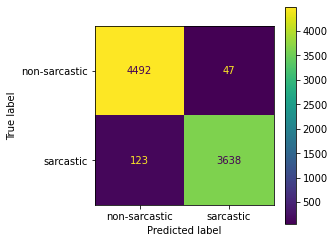

In [ ]:
#plotting the confusion matrix for validation data:

fig, ax = plt.subplots(1, figsize=(4,4))
cm_plot = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, test_predictions), display_labels=target_classes)
cm_plot.plot(ax=ax)

plt.show()

In [ ]:
validation_predictions = np.argmax(trainer.predict(validation_dataset)[0], axis=-1)

In [ ]:
print(f"Accuracy = {accuracy_score(validation_predictions, y_validation)}")
print(f"ROC AUC Score = {roc_auc_score(validation_predictions, y_validation)}")

Accuracy = 0.9768646824918665
ROC AUC Score = 0.9780499767685152


In [ ]:
# trainer.save_model('FineTunedBERT_Sarcasm')

## Testing on self-made data

In [ ]:
def test_for_sarcasm(s):
    text = []
    text.append(s)

    encodings = tokenizer(text, max_length=20, truncation=True, padding=True)
    dataset = tf.data.Dataset.from_tensor_slices((encodings, [0]))
    prediction = np.argmax(trainer.predict(dataset)[0], axis=-1)
    
    if prediction[0]>=0.5: 
        return "It is a sarcastic phrase!" 
    else: 
        return "It is not a sarcastic phrase!"

In [ ]:
test_for_sarcasm(s="You are a extraordinarily poor student. Get a life.")

'It is a sarcastic phrase!'